あるストリーミングサービスの解約率を調べるという状況を想定する  
まずはデータ生成を行う  

ここで解約率を推定するために利用できるデータは以下のものとする。

| 項目 | 説明 | 分布 | コメント |
| --- | --- | --- | --- |
| DaysSinceLastActivity | 最終ログインからの日数 | 指数分布: 平均10日 | 幽霊アカウントを含めたらこんな感じか？
| HasActivePromotionalOffer | 復帰を促したか | 二項分布: 0 or 1 | -- |
| AverageSessionDuration | 平均セッション時間 | ガンマ分布: (2,15) 平均30分 | 大体の通学時間を想定

In [184]:
using Random

Random.seed!(1234)
n_samples = 1000

1000

10-element Vector{Float64}:
  3.989805872320786
 10.97157487488112
 11.528800883195558
  0.32182180836827007
  9.852672831588938
 14.861479297186445
 44.69383545607664
  3.138659888253987
 10.057130392898497
 16.665226566676623

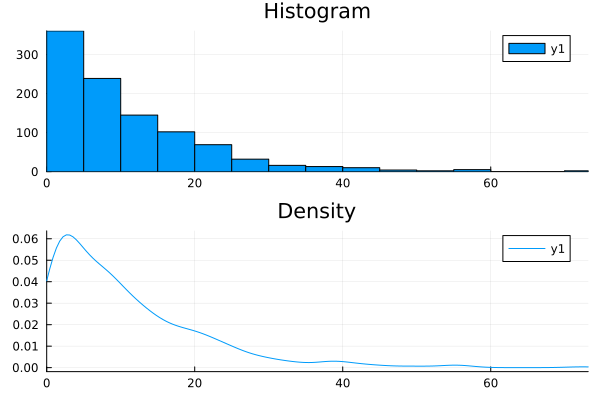

In [185]:
using Distributions
using StatsPlots

DaysSinceLastActivity = rand(Exponential(10), n_samples)
display(first(DaysSinceLastActivity, 10))

xlims_DSA=(0, maximum(DaysSinceLastActivity))
plot(
    histogram(
        DaysSinceLastActivity,
        title="Histogram",
        xlims=xlims_DSA
    ),
    density(
        DaysSinceLastActivity,
        title="Density",
        xlims=xlims_DSA
    ),
    layout=(2,1),
)

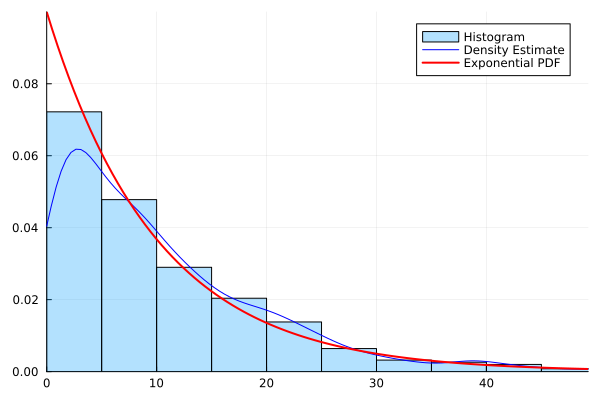

In [186]:
# Combined Histogram and Density plot on the same plot
plots_DaysSinceLastActivity = histogram(
    DaysSinceLastActivity,
    bins=30,
    normalize=true,   # Crucial for density plot
    fillalpha = 0.3,
    linecolor = :black,
    label = "Histogram",
    xlims = (0, quantile(DaysSinceLastActivity, 0.99))
)
density!(
    DaysSinceLastActivity,
    fillalpha = 0.6,
    linecolor = :blue,
    label = "Density Estimate",
)
# 指数関数の確率密度関数
x = range(0, quantile(DaysSinceLastActivity, 0.99), length=100)
plot!(
    x,
    pdf(Exponential(10), x),
    linewidth=2,
    color=:red,
    label="Exponential PDF"
)
display(plots_DaysSinceLastActivity)


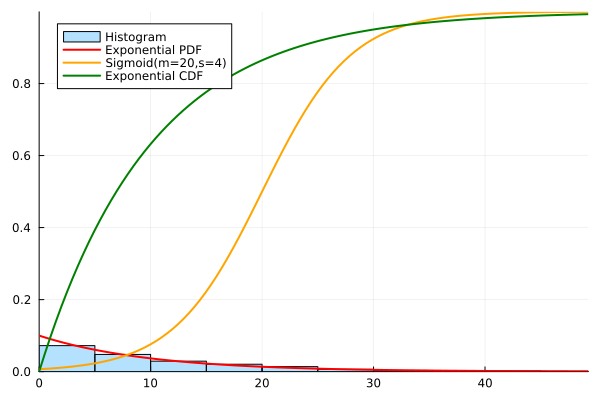

In [187]:
histogram(
    DaysSinceLastActivity,
    bins=30,
    normalize=true,   # Crucial for density plot
    fillalpha = 0.3,
    linecolor = :black,
    label = "Histogram",
    xlims = (0, quantile(DaysSinceLastActivity, 0.99))
)
plot!(
    x,
    pdf(Exponential(10), x),
    linewidth=2,
    color=:red,
    label="Exponential PDF"
)
sigmoid(x, m, s) = 1 ./ (1 .+ exp.(-(x .- m) ./ s))
plot!(
    x,
    sigmoid(x, 20, 4),
    linewidth=2,
    color=:orange,
    label="Sigmoid(m=20,s=4)"
)
plot!(
    x,
    cdf(Exponential(10), x),
    linewidth=2,
    color=:green,
    label="Exponential CDF"
)

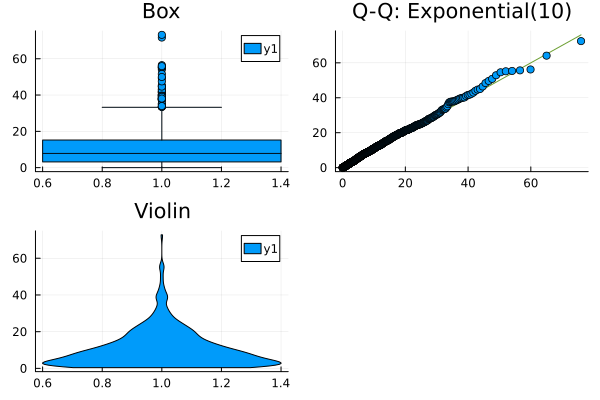

In [188]:
# その他のプロットたち
plot(
    boxplot(
        DaysSinceLastActivity,
        title="Box"
    ),
    qqplot(
        Exponential(10),
        DaysSinceLastActivity,
        title="Q-Q: Exponential(10)",
    ),
    violin(
        DaysSinceLastActivity,
        title="Violin"
    )
)

5-element Vector{Int64}:
 0
 1
 1
 0
 0

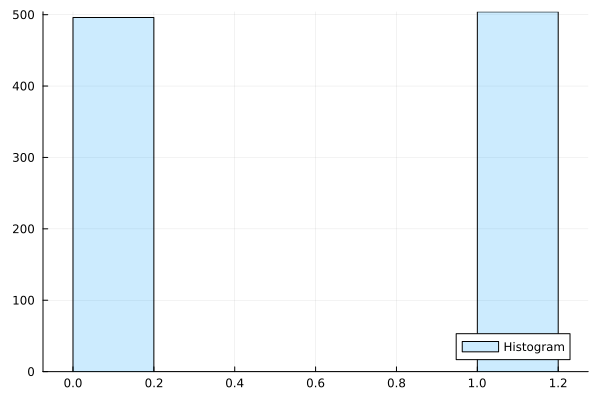

In [189]:
# 次はHasActivePromotionalOffer
HasActivePromotionalOffer = rand([0,1], n_samples)
display(first(HasActivePromotionalOffer, 5))
plots_HasActivePromotionalOffer = histogram(
    HasActivePromotionalOffer,
    fillalpha=0.2,
    label="Histogram"
)
display(plots_HasActivePromotionalOffer)

In [190]:
# AverageSessionDuration
# これはガンマ分布(2,15)
AverageSessionDuration = rand(Gamma(2,15), n_samples)
display(first(AverageSessionDuration, 5))

5-element Vector{Float64}:
 39.26013305811533
 63.38556973255818
 29.298779615357244
 37.88617281099633
 59.433326040070746

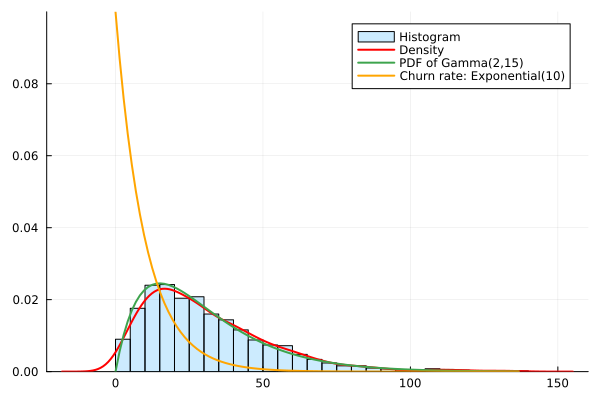

In [191]:
# density & ガンマ分布のpdfも併記
plots_AverageSessionDuration = histogram(
    AverageSessionDuration,
    normalize=true,
    fillalpha=0.2,
    label="Histogram",
)
density!(
    AverageSessionDuration,
    label="Density",
    color="red",
    linewidth=2
)
x = range(0, maximum(AverageSessionDuration), length=100)
plot!(
    x,
    pdf(Gamma(2,15), x),
    label="PDF of Gamma(2,15)",
    linewidth=2
)
lambda = 10
plot!(
    x,
    pdf(Exponential(lambda), x),
    color="orange",
    linewidth=2,
    label="Churn rate: Exponential($lambda)"
)
display(plots_AverageSessionDuration)

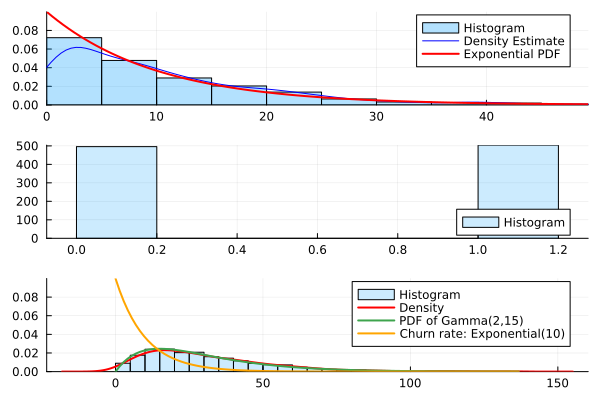

In [192]:
# 3つを並べて表示
plot(
    plots_DaysSinceLastActivity,
    plots_HasActivePromotionalOffer,
    plots_AverageSessionDuration,
    layout=(3,1)
)


# 解約についてのユーザー設定
解約グループと、そうではない通常グループについての設定（振る舞い）を定義する。

# 最終ログインからの時間 (DaysSinceLastActivity)
- DaysSinceLastActivityは指数分布に従うデータ
- 最終ログインからの時間が長いほど解約率が上がる
- 解約率はシグモイド間数でモデル化
  - 変動させるのは中間パラメータmのみ
  - スケールパラメータmの変更は行わない
## 解約グループ
- 解約グループは解約までの判断が早いと想定
- このユーザは見切りが早く、あっさりと他のサービスに乗り換えてしまう
- 通常m=20のところ、このグループの閾値はm=10とする

# プロモーション (HasActivePromotionalOffer)
- HasActivePromotionalOfferは、行うか行わないかのベルヌーイ分布(0.5)
- プロモーション実施はコストの問題のため全員に行うことはできず、実施確率は５０％となっている
## 解約グループ
- プロモーションは実際効果的であった
- 実際、解約グループはプロモーションを全体で２割しか受け取っていない

# セッション時間 (AverageSessionDuration)
- AverageSessionDurationgはガンマ分布に従うデータ
- おおよそこのサービスは平均的に３０分再生されている
- そして解約率は平均再生時間に比例して下がる
  - つまり解約率は平均再生時間の指数分布とモデル化できる
  - 指数関数のlambdaを変更することで解約の度合いを変えられる
## 解約グループ
- 解約グループは平均再生時間が仮に長かったとしても、あっさりと解約を行なってしまう
- 通常が平均５０に対し、解約グループは１０
  - 解約グループは見切りを付けるのが速い
  - 再生時間が短い場合、解約をすることをためらわない

In [193]:
# データの作成は完了
# 次は解約率の設定とそのラベルの作成

labels = zeros(Int, n_samples)

p_churn = 0.1

infl_session_roof = pdf(Exponential(10), 0)
# 解約をシミュレーションしてラベル作成
for i=1:n_samples
    # 最後の活動からの時刻から計算される解約尤度
    infl_activity = sigmoid(DaysSinceLastActivity[i], 20, 4)
    # プロモーションを打っていれば、解約しずらいよう減衰を抑える
    infl_promotion = pdf(Bernoulli(0.4), HasActivePromotionalOffer[i])
    # セッション時間が短いほど解約率は急激に上がる
    infl_session = pdf(Exponential(30), AverageSessionDuration[i])
    churn_influence = p_churn *
        infl_activity *
        infl_promotion *
        infl_session
    no_churn_influence = (1 - p_churn) *
        (1 - infl_activity) *
        (1 - infl_promotion) *
        (infl_session_roof - infl_session)
    influence_norm = churn_influence / (churn_influence + no_churn_influence)
    labels[i] = rand() < influence_norm ? 1 : 0
    println(DaysSinceLastActivity[i], '\t', HasActivePromotionalOffer[i], '\t', AverageSessionDuration[i])
    println(churn_influence, "\t" ,no_churn_influence)
    println("P$i:\t", influence_norm)
end

println("Average churn: $(mean(labels))")

3.989805872320786	0	39.26013305811533
9.694693547736084e-6	0.03217013681943802
P1:	0.00030126613757514286
10.97157487488112	1	63.38556973255818
1.5270877651621213e-5	0.04691422356476531
P2:	0.0003254004295818436
11.528800883195558	1	29.298779615357244
5.391553391851517e-5	0.042150974026116624
P3:	0.0012774712712332063
0.32182180836827007	0	37.88617281099633
4.100912715318902e-6	0.03236953783302791
P4:	0.00012667444483231363
9.852672831588938	0	59.433326040070746
2.022292777877033e-5	0.03182696541209191
P5:	0.0006349988439466883
14.861479297186445	1	41.39915852998937
7.271263423293026e-5	0.03874787240161586
P6:	0.0018730432363598826
44.69383545607664	1	32.24373920531192
0.00045421206746918026	9.952388433384003e-5
P7:	0.8202683354588407
3.138659888253987	0	25.04317709395092
1.2630764490924268e-5	0.030344217580977453
P8:	0.0004160762786433911
10.057130392898497	1	26.82497734562342
4.1912062472580475e-5	0.04305400030289054
P9:	0.0009725298798005231
16.665226566676623	0	64.12599349963237
7.


2.5442336479016726e-5	0.04236886619988142
P96:	0.0006001356634274511
3.3304464679286703	0	27.43845896528525
1.222551175103883e-5	0.03071607718687012
P97:	0.00039785834808205706
55.05416012670718	1	29.26127494243163
0.0005026555790299818	7.3796786152545816e-6
P98:	0.9855310422080906
3.7801058773825975	0	15.451825528106705
2.0362209183895245e-5	0.028339143488754777
P99:	0.0007180029652412201
71.67091160067953	0	55.969673128398334
0.0003095885737193039	8.37907057799992e-8
P100:	0.9997294214292077
5.802942793778222	0	54.35605591685796
9.128754404054896e-6	0.033088657182035894
P101:	0.00027581163349069625
0.027279855012593435	0	71.71497867076354
1.2342481334067304e-6	0.03466581778259975
P102:	3.560291576891339e-5
5.224274313111077	1	22.843274280045026
1.511206991539977e-5	0.04448755403906343
P103:	0.00033957673183878685
0.21232196714942728	0	6.690857345991452
1.1289512908628763e-5	0.026212648434762263
P104:	0.0004305041039662563
26.436030189813245	0	1.9484475893720057
0.0015617478807617691